Here we will attempt to crop the MIAS images in the same manner that was used to created dataset 9. That will involve:

1. Increasing the size of the raw images so they are on the same scale as the DDSM images.
2. For abnormal images extracting the ROI and taking three random crops of it.
3. For normal images extracting tiles with no zoom.

The MIAS images are all sized to 1024x1024 squares, with the height the constraining dimension. The heights of the CBIS-DDSM images range from 4136 pixels to 6931 pixels, with a mean on 5295 and a standard deviation of 668. As the tiles are then sized down by half on each dimension we can cut these numbers in half and then transform the MIAS images in the same way and extract the MIAS tiles directly at 299x299.

To scale to the mean height of the CBIS-DDSM images would increase the height by 2.58, we could account for the variance in the heights of the CBIS images as well scaling randomly, but I am not sure if that is necessary.

In [1]:
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
import math
import random
import os
from scipy.misc import imresize
from mammo_utils import remove_white_from_image, slice_normal_image, create_slices, read_pgm, get_roi_edges, get_fuzzy_offset, get_roi_edges, random_flip_image, progress, extract_slice
%matplotlib inline

In [11]:
def get_image_class(df, idx):
     # get the name of the image from the data
    img_name = df.loc[idx]['path']
    severity = df.loc[idx]['SEVERITY']
    img_class = df.loc[idx]['CLASS']
    
    if severity == "M":
        img_label = "MALIGNANT_"
        if img_class == "NORM":
            img_label = "NORMAL"
        elif img_class == "CALC":
            img_label = img_label + "calcification"
        else:
            img_label = img_label + "mass"
    elif severity == "B":
        img_label = "BENIGN_"
        if img_class == "CALC":
            img_label = img_label + "calcification"
        elif img_class == "NORM":
            img_label = "NORMAL"
        else:
            img_label = img_label + "mass"
    else:
        img_label = "NORMAL"
    
    return img_label

def trim_image_margins(img):
    img_h = img.shape[0]
    img_w = img.shape[1]
    
    # get which columns are all black
    black_pixels = np.sum(img == 0, axis=0)
    
    blank_cols = (black_pixels >= (img_h - 10))
    
    # first trim from the left
    first_col = np.argmax(~blank_cols)
    
    # now trim from the right
    last_col = img_w - np.argmax(~np.flip(blank_cols, axis=0))
    #last_col = 0
    
    img = img[:,first_col:last_col]
    
    return img, first_col, last_col
    
def get_random_scale(scale_by):
    # get the random factor
    random_scale_by = np.random.normal(loc=scale_by, scale=(scale_by * 0.4), size=None)
    
    # if the scale by is within a range return it, else keep trying until it is within the range
    if (random_scale_by > 1.5) and (random_scale_by < 2.75):
        return random_scale_by
    else:
        return get_random_scale(scale_by)

def random_crop_image(img, slice_size=299, tile_size=299):
    img_h = img.shape[0]
    img_w = img.shape[1]
    
    # make sure the image is big enough to use
    if (img_h < slice_size) or (img_w < slice_size):
        print("Error - image is wrong size!", img.shape)
        return np.array([0])
    
    # pick a random place to start the crop so that the crop will be the right size
    start_row = np.random.randint(low=0, high=(img_h - slice_size))
    start_col = np.random.randint(low=0, high=(img_w - slice_size))
    
    end_row = start_row + slice_size
    end_col = start_col + slice_size
    
    # crop the image and randomly rotate it
    cropped_img = random_flip_image(img[start_row:end_row, start_col:end_col])
    
    # make sure the image is the right size
    if cropped_img.shape[0] == cropped_img.shape[1]:
        # resize it and return it
        cropped_img = imresize(cropped_img, (tile_size,tile_size))
        return cropped_img.reshape((tile_size, tile_size, 1))
    
    # else repeat until the image is the right size
    else:
        return random_crop_image(img)    
    
## Copy of function used to crop cbis images, but altered to deal with MIAS images
## returns: numpy array of images and list of corresponding file names
def create_mias_slices(df, pgm_dir="E:\\Documents\\Mammography\\MIAS\\pgms\\", scale_by=2.58, slice_size=299, var_upper_threshold=2000, var_lower_threshold=20, mean_threshold=38, debug=None):
    # loop through rows in the data frame
    slices_list = []
    image_names_list = []
    labels_list = []
    full_slice_size = slice_size
    
    counter = 0
    if debug is None:
        progress(counter, len(df), 'WORKING')
    
    for index, row in all_cases_df.iterrows():
        
        # get the base file name from the mask name
        image_name = row['path']
        
        # create a progress bar
        counter += 1
        if debug is None:
            progress(counter,  len(df), image_name)
            
        # try to open the image, if it doesn't exist continue
        try:
            full_image_arr = read_pgm(pgm_dir + image_name)
        except:
            print(image_name, "file not found!")
            continue       
        
        # get rid of the extra dimensions with unneccessary info
        image_h, image_w = full_image_arr.shape
        
        # scale the images up by 2.58 so they are the same scale as the DDSM images
        new_size = int(image_h * scale_by)
        full_image_arr = imresize(full_image_arr, (new_size, new_size))

        # get the new shape of the image
        image_h, image_w = full_image_arr.shape
            
        # get the class of the image
        image_class = get_image_class(df, index)
        if debug is True:
            print(image_name, image_class)
        
        # if the image is abnormal
        if image_class != "NORMAL":            
            if debug is True:
                print(image_name, "abnormal")
            
            # if the image doesn't have ROI data skip it
            if np.isnan(row['X']):
                continue
            
            # get the size and shape of the ROI, NOT offset by the number of columns trimmed off
            center_col = int(row['X'] * scale_by)
            center_row = image_h - int(row['Y'] * scale_by)

            # the ROI is square so we don't need to get the sizes individually
            roi_size = mask_height = mask_width = mask_size = row['RADIUS'] * scale_by

            ###########################################################################
            ## Extract the ROI depending on it's size
            # if the ROI is smaller than a slice extract it with some padding
            if roi_size < full_slice_size:
                ## Make sure the size of the ROI is at least as big as a tile will be
                adj_mask_height = int(np.max([full_slice_size * 1.2, mask_height]))
                adj_mask_width = int(np.max([full_slice_size * 1.2, mask_width]))

                ## Extract the full ROI with 20% padding on either side
                start_row = int(np.max([center_row - (adj_mask_height // 2), 0]))
                end_row = start_row + adj_mask_height
                if end_row > image_h:
                    end_row = image_h
                    start_row = image_h - adj_mask_height

                start_col = int(np.max([center_col - (adj_mask_width // 2), 0]))
                end_col = start_col + adj_mask_width
                if end_col > image_w:
                    end_col = image_w
                    start_col = image_w - adj_mask_width

                # extract the ROI and randomly flip it
                roi_img = random_flip_image(full_image_arr[start_row:end_row, start_col:end_col])
                
            # else just extract the ROI with no padding
            else:
                # we will still use a small amount of padding as it is necessary for the random cropping
                adj_mask_height = int(np.max([full_slice_size * 1.05, mask_height]))
                adj_mask_width = int(np.max([full_slice_size * 1.05, mask_width]))

                start_row = np.max([center_row - (adj_mask_height // 2), 0])
                end_row = start_row + adj_mask_height
                if end_row > image_h:
                    end_row = image_h
                    start_row = image_h - adj_mask_height

                start_col = np.max([center_col - (adj_mask_width // 2), 0])
                end_col = start_col + adj_mask_width
                if end_col > image_w:
                    end_col = image_w
                    start_col = image_w - adj_mask_width

                # extract the ROI and randomly flip it
                roi_img = random_flip_image(full_image_arr[start_row:end_row, start_col:end_col])
                
            ###########################################################################
            ## Now we have an image that is just the ROI, with or without padding
            ## Take 3 random crops from it
            slice_1 = random_crop_image(roi_img)
            slice_2 = random_crop_image(roi_img)
            slice_3 = random_crop_image(roi_img)

            # for each of the slices, if it is sized properly add it to the list
            if (slice_1.shape[0] == slice_size) and (slice_1.shape[1] == slice_size):
                slices_list.append(slice_1)
                image_names_list.append(image_name)
                labels_list.append(image_class)

            if (slice_2.shape[0] == slice_size) and (slice_2.shape[1] == slice_size):
                slices_list.append(slice_2)
                image_names_list.append(image_name)
                labels_list.append(image_class)

            if (slice_3.shape[0] == slice_size) and (slice_3.shape[1] == slice_size):
                slices_list.append(slice_3)
                image_names_list.append(image_name)
                labels_list.append(image_class)
                
        ## ELse if the image is normal
        else:
            if debug is not None:
                print(image_name, " creating tiles")
            
            # remove the margins
            full_image_arr, _, _ = trim_image_margins(full_image_arr)
            
            # slice the image into 299x299 tiles
            size = 299
            stride = 200
            tiles = [full_image_arr[x:x+size,y:y+size] for x in range(0,full_image_arr.shape[0],stride) for y in range(0,full_image_arr.shape[1],stride)]
            usable_tiles = []

            # for each tile:
            for i in range(len(tiles)):
                # make sure tile has correct shape
                if tiles[i].shape == (size,size):
                    # make sure the tile doesn't have too many white or black pixels, that indicates it is not useful
                    if (np.sum(np.sum(tiles[i] >= 225)) < 100) and (np.sum(np.sum(tiles[i] <= 20)) <= 50000):
                        # make sure tile has stuff in it
                        if np.mean(tiles[i]) >= mean_threshold:
                            # make sure the tile contains image and not mostly empty space
                            if np.var(tiles[i]) <= var_upper_threshold:
                                if np.var(tiles[i]) >= var_lower_threshold:
                                    # flip a coin to decide whether to include the tile
                                    coin = np.random.binomial(1, 0.3)
                                    if coin:
                                        # reshape the tile so they will work with the convnet
                                        slices_list.append(random_flip_image(tiles[i].reshape(299,299,1)))
                                        image_names_list.append(image_name)
                                        labels_list.append(image_class)

    return np.array(slices_list), np.array(labels_list), image_names_list

In [12]:
# import and clean the annotation data, this time leave the duplicates
all_cases_df = pd.read_table('data/Info.txt', delimiter=' ')
all_cases_df = all_cases_df[all_cases_df.columns[:-1]] # drop last column
all_cases_df['path'] = all_cases_df['REFNUM'].map(lambda x: '%s.pgm' % x)

In [13]:
slices, labels, filenames = create_mias_slices(all_cases_df, debug=True)

C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\scipy\misc\pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\scipy\misc\pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


mdb001.pgm BENIGN_mass
mdb001.pgm abnormal
mdb002.pgm BENIGN_mass
mdb002.pgm abnormal
mdb003.pgm NORMAL
mdb003.pgm  creating tiles
mdb004.pgm NORMAL
mdb004.pgm  creating tiles
mdb005.pgm BENIGN_mass
mdb005.pgm abnormal
mdb005.pgm BENIGN_mass
mdb005.pgm abnormal
mdb006.pgm NORMAL
mdb006.pgm  creating tiles
mdb007.pgm NORMAL
mdb007.pgm  creating tiles
mdb008.pgm NORMAL
mdb008.pgm  creating tiles
mdb009.pgm NORMAL
mdb009.pgm  creating tiles
mdb010.pgm BENIGN_mass
mdb010.pgm abnormal
mdb011.pgm NORMAL
mdb011.pgm  creating tiles
mdb012.pgm BENIGN_mass
mdb012.pgm abnormal
mdb013.pgm BENIGN_mass
mdb013.pgm abnormal
mdb014.pgm NORMAL
mdb014.pgm  creating tiles
mdb015.pgm BENIGN_mass
mdb015.pgm abnormal
mdb016.pgm NORMAL
mdb016.pgm  creating tiles
mdb017.pgm BENIGN_mass
mdb017.pgm abnormal
mdb018.pgm NORMAL
mdb018.pgm  creating tiles
mdb019.pgm BENIGN_mass
mdb019.pgm abnormal
mdb020.pgm NORMAL
mdb020.pgm  creating tiles
mdb021.pgm BENIGN_mass
mdb021.pgm abnormal
mdb022.pgm NORMAL
mdb022.pgm  cr

mdb182.pgm NORMAL
mdb182.pgm  creating tiles
mdb183.pgm NORMAL
mdb183.pgm  creating tiles
mdb184.pgm MALIGNANT_mass
mdb184.pgm abnormal
mdb185.pgm NORMAL
mdb185.pgm  creating tiles
mdb186.pgm MALIGNANT_mass
mdb186.pgm abnormal
mdb187.pgm NORMAL
mdb187.pgm  creating tiles
mdb188.pgm BENIGN_mass
mdb188.pgm abnormal
mdb189.pgm NORMAL
mdb189.pgm  creating tiles
mdb190.pgm BENIGN_mass
mdb190.pgm abnormal
mdb191.pgm BENIGN_mass
mdb191.pgm abnormal
mdb192.pgm NORMAL
mdb192.pgm  creating tiles
mdb193.pgm BENIGN_mass
mdb193.pgm abnormal
mdb194.pgm NORMAL
mdb194.pgm  creating tiles
mdb195.pgm BENIGN_mass
mdb195.pgm abnormal
mdb196.pgm NORMAL
mdb196.pgm  creating tiles
mdb197.pgm NORMAL
mdb197.pgm  creating tiles
mdb198.pgm BENIGN_mass
mdb198.pgm abnormal
mdb199.pgm BENIGN_mass
mdb199.pgm abnormal
mdb200.pgm NORMAL
mdb200.pgm  creating tiles
mdb201.pgm NORMAL
mdb201.pgm  creating tiles
mdb202.pgm MALIGNANT_mass
mdb202.pgm abnormal
mdb203.pgm NORMAL
mdb203.pgm  creating tiles
mdb204.pgm BENIGN_mas

In [14]:
print("Slices:", slices.shape)
print("Labels:", labels.shape)
print("Filenames:", len(filenames))

Slices: (3075, 299, 299, 1)
Labels: (3075,)
Filenames: 3075


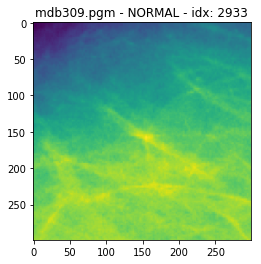

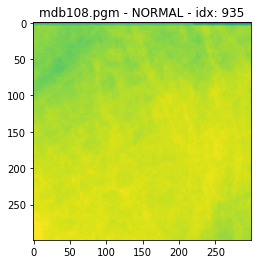

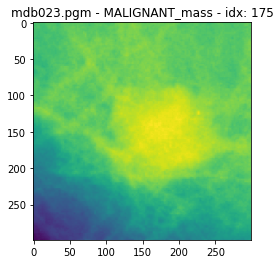

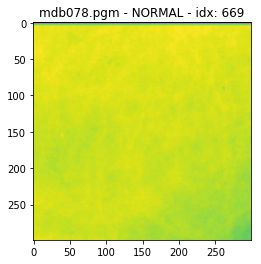

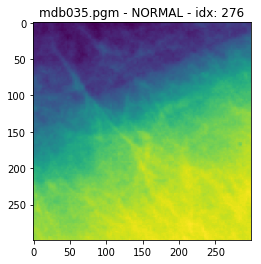

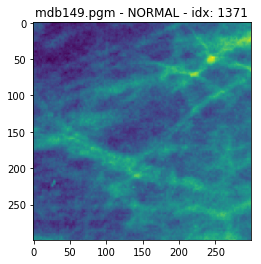

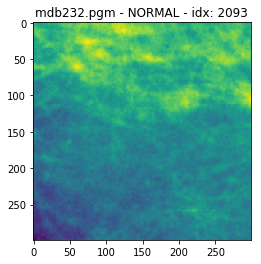

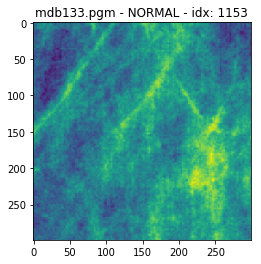

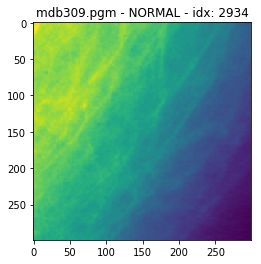

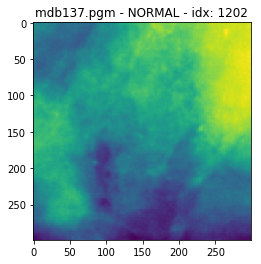

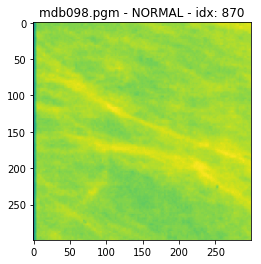

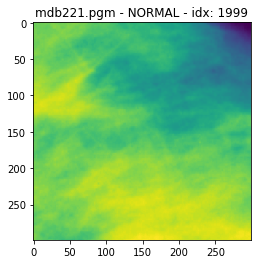

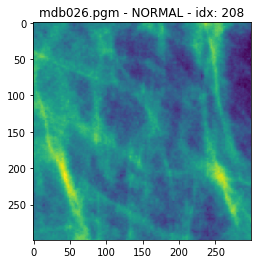

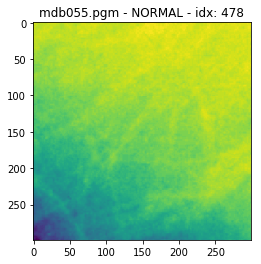

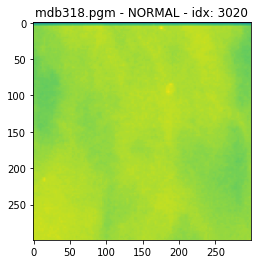

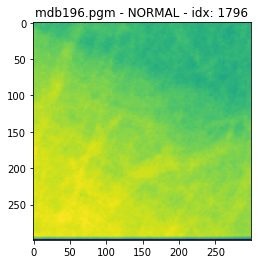

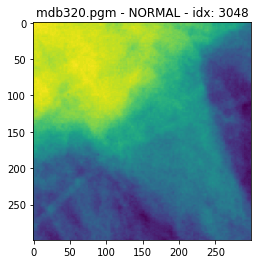

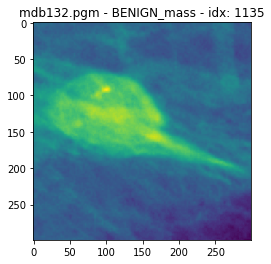

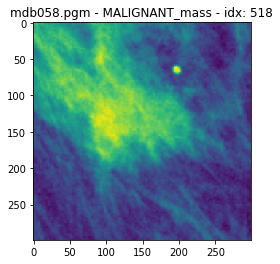

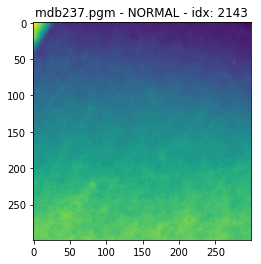

In [15]:
# look at some random images
N = 20
idxs = random.sample(range(len(slices)), k=N)

for idx in idxs:
    plt.imshow(slices[idx].reshape(299,299))
    plt.title(filenames[idx] + " - " + labels[idx] + " - idx: " + str(idx))
    plt.show()

In [16]:
pd.value_counts(labels, normalize=True)

NORMAL                     0.883902
BENIGN_mass                0.051707
MALIGNANT_mass             0.038049
BENIGN_calcification       0.014634
MALIGNANT_calcification    0.011707
dtype: float64

In [17]:
# encode the labels
from sklearn import preprocessing

# load the classes used to encode the other data
classes = np.load(os.path.join("data", "all_classes.npy"))

# create the encoder
le = preprocessing.LabelEncoder()
le.fit(labels)

# we want normal to be 0, so we'll do some transformations here
labels_enc = le.transform(labels) + 1
labels_enc[labels_enc == 5] = 0

# make sure the classes match how the other labels were encoded
mias_classes = le.classes_
mias_classes = np.insert(mias_classes, 0, 'NORMAL', axis=0)
mias_classes = mias_classes[0:5]

print("MIAS Classes", mias_classes)
print("Training Classes", classes)

MIAS Classes ['NORMAL' 'BENIGN_calcification' 'BENIGN_mass' 'MALIGNANT_calcification'
 'MALIGNANT_mass']
Training Classes ['NORMAL' 'BENIGN_calcification' 'BENIGN_mass' 'MALIGNANT_calcification'
 'MALIGNANT_mass']


In [18]:
## save the data
np.save(os.path.join("data", "all_mias_slices9.npy"), slices)
np.save(os.path.join("data", "all_mias_labels9.npy"), labels_enc)
np.save(os.path.join("data", "all_mias_filenames9.npy"), filenames)